# End-user generated time series analysis using Zarr data in xarray

This notebook describes the python-based Zarr time series approach as part of the TRT-43 time series technology study. This notebook was adapted from the [Pangeo AGU Ocean Sciences 2020 tutorial](https://github.com/pangeo-gallery/osm2020tutorial) with credits below:

### Credits: Tutorial development
Dr. Chelle Gentemann - Twitter - Farallon Institute

Lucas Sterzinger - Twitter - University of California, Davis
  
### Compute Resources
This notebook was developed and run using an AWS m5.2xlarge instance as this is what was utilized in the Pangeo workshop via their OHW JupyterHub. This has 8 vCPU and 32 GB memory. 

# Dataset used: Multi-Scale Ultra High Resolution (MUR) Sea Surface Temperature (SST)

Found from the AWS Open Registry:

- Click here: [AWS Public Dataset](https://aws.amazon.com/opendata/)
- Click on `Find public available data on AWS` button
- Search for MUR
- Select [MUR SST](https://registry.opendata.aws/mur/)

 
 
 
 

-------------------------------------------------------

![](./awsmur.png)



## [MUR SST](https://podaac.jpl.nasa.gov/Multi-scale_Ultra-high_Resolution_MUR-SST) [AWS Public dataset program](https://registry.opendata.aws/mur/) 

### Access the MUR SST Zarr store which is in an s3 bucket.  

![image](https://podaac.jpl.nasa.gov/Podaac/thumbnails/MUR-JPL-L4-GLOB-v4.1.jpg)

We will start with my favorite Analysis Ready Data (ARD) format: [Zarr](https://zarr.readthedocs.io/en/stable/).  Using data stored in Zarr is fast, simple, and contains all the metadata normally in a netcdf file, so you can figure out easily what is in the datastore.  

- Fast - Zarr is fast because all the metadata is consolidated into a .json file.  Reading in massive datasets is lightning fast because it only reads the metadata and does read in data until it needs it for compute.

- Simple - Filenames?  Who needs them? Who cares?  Not I.  Simply point your read routine to the data directory.

- Metadata - all you want!

## Import Libraries

You may need to pip install these libraries depending on your python environment

In [1]:
# pip install xarray
# pip install s3fs
# pip install dask

In [2]:
# filter some warning messages
import warnings 
warnings.filterwarnings("ignore") 

#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from statistics import mean
from statistics import stdev
# make datasets display nicely
xr.set_options(display_style="html")  

import dask
from dask.distributed import performance_report, Client, progress

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


[fsspec.get_mapper](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=get_mapper#fsspec.get_mapper) Creates a mapping between your computer and the s3 bucket.  This isn't necessary if the Zarr file is stored locally.

[xr.open_zarr](http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html) Reads a Zarr store into an Xarray dataset


## Open zarr dataset

In [3]:
# %%time
# file_location = 's3://mur-sst/zarr'

# ikey = fsspec.get_mapper(file_location, anon=True)

# ds_sst = xr.open_zarr(ikey,consolidated=True)

# ds_sst

## Testing scenarios

Based on https://wiki.earthdata.nasa.gov/display/TRT/Test+Scenarios

Spatial Constraints:



Single grid cell	(-129.995, 39.995, -129.995, 39.995)	/analysed_sst[][5000][5000];/time;/lat[5000];/lon[5000]	(-129.95, 39.95, -129.95, 39.95)	
10x10 grid cells	(-129.995, 39.995, -129.905, 39.905)	/analysed_sst[][5000:5009][5000:5009];/time;/lat[5000:5009];/lon[5000:5009]	(-129.95, 39.95, -129.86, 39.86)	
3x3 grid cells	(-129.995, 39.995, -129.975, 39.975)	/analysed_sst[][5000:5002][5000:5002];/time;/lat[5000:5002];/lon[5000:5002]	(-129.95, 39.95, -129.93, 39.93)	

Temporal Constraints


100	2003-01-01/2003-04-10	2000-06-01/2000-06-03
1000	
2003-01-01/2005-09-27

2000-06-01/2000-06-21
7014	2002-05-31/2021-08-12	
100000	
2000-06-01/2006-02-13
366625	
2000-06-01/2021-04-30
1,000,000	


### Test 1:
Single Grid Cell; 100 time slices

In [4]:
times = []
for i in range(10):
    t0 = time.time()
    file_location = 's3://mur-sst/zarr'

    ikey = fsspec.get_mapper(file_location, anon=True)

    ds_sst = xr.open_zarr(ikey,consolidated=True)
    
    sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2003-01-01','2003-04-10'),
                                            lat  = 40,
                                            lon  = -130 
                                           ).load()
    
    wall_time = time.time() - t0
    times.append(wall_time)
    print (wall_time, "seconds wall time")
    ds_sst 
    
print("mean wall time:", mean(times), "stdev wall time:", stdev(times))

4.110254287719727 seconds wall time
4.079364061355591 seconds wall time
3.7480313777923584 seconds wall time
3.9838693141937256 seconds wall time
3.8066048622131348 seconds wall time
3.973721742630005 seconds wall time
3.9275424480438232 seconds wall time
3.763192892074585 seconds wall time
3.953015089035034 seconds wall time
3.91405987739563 seconds wall time
mean wall time: 3.925965595245361 stdev wall time: 0.1231103086145939


In [5]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 100)>
array([285.659  , 285.73898, 285.69098, 285.64398, 285.478  , 285.541  ,
       285.589  , 286.098  , 286.11798, 286.05   , 285.817  , 285.99   ,
       286.154  , 286.326  , 286.348  , 286.218  , 286.20398, 286.261  ,
       286.25598, 286.082  , 285.943  , 285.974  , 286.037  , 285.99   ,
       285.822  , 285.50998, 285.675  , 285.718  , 285.72998, 285.94598,
       285.828  , 285.779  , 285.891  , 285.719  , 285.763  , 285.637  ,
       285.391  , 285.11798, 285.155  , 285.184  , 285.192  , 285.113  ,
       284.938  , 284.86398, 285.042  , 285.086  , 284.987  , 285.123  ,
       285.19   , 285.149  , 285.11   , 285.21298, 285.24298, 285.336  ,
       285.414  , 285.36   , 285.031  , 284.741  , 285.02798, 285.082  ,
       285.039  , 284.97598, 285.099  , 285.109  , 284.98898, 284.90198,
       284.85   , 285.168  , 285.189  , 285.349  , 285.19598, 285.043  ,
       284.878  , 284.64798, 284.754  , 284.867  , 284.87698, 284.753  ,
       284.81   , 284.813  , 284.86   , 284.839  , 284.762  , 284.925  ,
       285.198  , 285.069  , 285.451  , 285.953  , 286.16998, 285.981  ,
       285.775  , 284.95398, 284.807  , 284.82098, 284.69098, 284.514  ,
       284.43298, 284.474  , 284.567  , 284.74   ], dtype=float32)
Coordinates:
    lat      float32 40.0
    lon      float32 -130.0
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-04-10T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

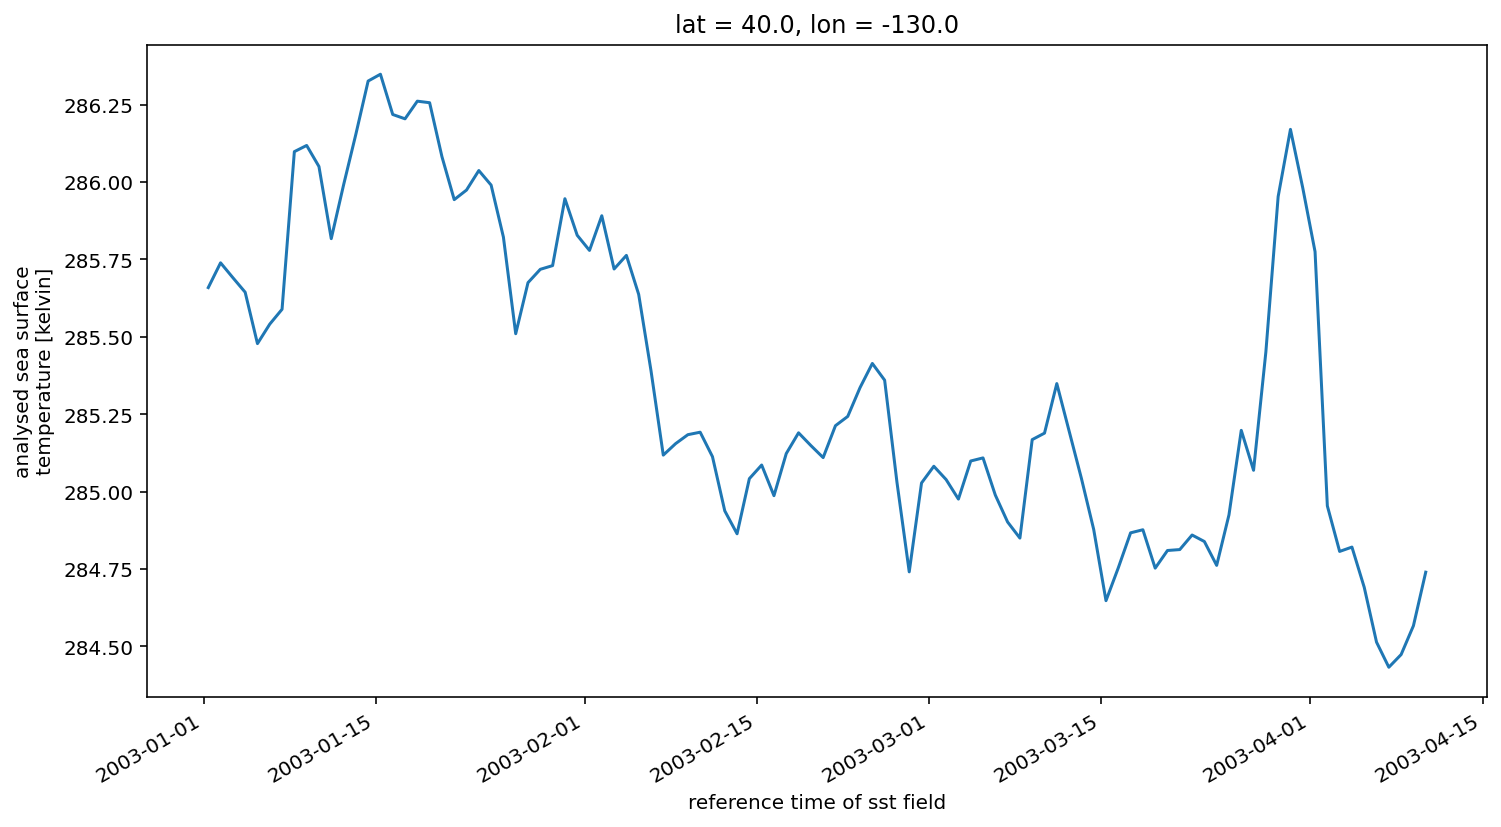

In [6]:
sst_timeseries.plot()

### Test 2:
Single Grid Cell; 1000 time slices

In [7]:
times = []
for i in range(10):
    t0 = time.time()
    file_location = 's3://mur-sst/zarr'

    ikey = fsspec.get_mapper(file_location, anon=True)

    ds_sst = xr.open_zarr(ikey,consolidated=True)
    
    sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2003-01-01','2005-09-26'),
                                            lat  = 40,
                                            lon  = -130 
                                           ).load()
    
    wall_time = time.time() - t0
    times.append(wall_time)
    print (wall_time, "seconds wall time")
    ds_sst 
    
print("mean wall time:", mean(times), "stdev wall time:", stdev(times))

4.12937331199646 seconds wall time
4.048696279525757 seconds wall time
3.706251382827759 seconds wall time
5.582850933074951 seconds wall time
3.895120859146118 seconds wall time
3.8892781734466553 seconds wall time
3.7328953742980957 seconds wall time
4.1792755126953125 seconds wall time
3.9520390033721924 seconds wall time
3.832742214202881 seconds wall time
mean wall time: 4.094852304458618 stdev wall time: 0.5454726271780478


In [8]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 1000)>
array([285.659  , 285.73898, 285.69098, 285.64398, 285.478  , 285.541  ,
       285.589  , 286.098  , 286.11798, 286.05   , 285.817  , 285.99   ,
       286.154  , 286.326  , 286.348  , 286.218  , 286.20398, 286.261  ,
       286.25598, 286.082  , 285.943  , 285.974  , 286.037  , 285.99   ,
       285.822  , 285.50998, 285.675  , 285.718  , 285.72998, 285.94598,
       285.828  , 285.779  , 285.891  , 285.719  , 285.763  , 285.637  ,
       285.391  , 285.11798, 285.155  , 285.184  , 285.192  , 285.113  ,
       284.938  , 284.86398, 285.042  , 285.086  , 284.987  , 285.123  ,
       285.19   , 285.149  , 285.11   , 285.21298, 285.24298, 285.336  ,
       285.414  , 285.36   , 285.031  , 284.741  , 285.02798, 285.082  ,
       285.039  , 284.97598, 285.099  , 285.109  , 284.98898, 284.90198,
       284.85   , 285.168  , 285.189  , 285.349  , 285.19598, 285.043  ,
       284.878  , 284.64798, 284.754  , 284.867  , 284.87698, 284.753  ,
       284.81   , 284.813  , 284.86   , 284.839  , 284.762  , 284.925  ,
       285.198  , 285.069  , 285.451  , 285.953  , 286.16998, 285.981  ,
       285.775  , 284.95398, 284.807  , 284.82098, 284.69098, 284.514  ,
       284.43298, 284.474  , 284.567  , 284.74   , 284.874  , 284.817  ,
       284.931  , 284.97   , 285.12698, 285.08398, 285.284  , 285.426  ,
       285.452  , 285.521  , 285.50198, 285.507  , 285.475  , 285.34   ,
       285.253  , 285.162  , 285.123  , 285.065  , 285.13498, 285.166  ,
...
       287.58   , 287.718  , 287.705  , 287.72598, 287.64398, 287.53998,
       287.46698, 287.626  , 287.664  , 287.733  , 287.883  , 287.846  ,
       287.965  , 287.677  , 287.629  , 287.56198, 287.22998, 286.671  ,
       287.54898, 287.93298, 288.022  , 288.115  , 287.848  , 287.668  ,
       287.789  , 287.779  , 287.655  , 287.697  , 287.77798, 287.91   ,
       287.943  , 287.895  , 287.91498, 287.935  , 287.97   , 288.569  ,
       288.992  , 288.983  , 288.92398, 288.934  , 288.998  , 289.072  ,
       289.137  , 289.025  , 288.931  , 288.624  , 288.682  , 288.672  ,
       288.694  , 288.79898, 288.88   , 288.807  , 288.951  , 289.15698,
       289.225  , 289.201  , 289.104  , 289.642  , 289.625  , 289.611  ,
       289.672  , 289.732  , 290.169  , 290.233  , 290.359  , 290.349  ,
       290.365  , 290.378  , 290.438  , 290.494  , 290.479  , 290.423  ,
       290.412  , 290.038  , 290.005  , 289.93   , 290.22998, 290.44598,
       290.66   , 290.568  , 290.807  , 291.318  , 291.374  , 291.283  ,
       291.305  , 291.41098, 291.57498, 291.728  , 291.727  , 291.665  ,
       291.783  , 291.738  , 291.708  , 291.57498, 291.82098, 291.919  ,
       291.899  , 291.472  , 291.36798, 291.41098, 291.62698, 291.642  ,
       291.66998, 291.763  , 291.675  , 291.363  , 291.525  , 291.53198,
       291.535  , 291.544  , 291.64798, 291.712  , 291.66   , 291.762  ,
       291.639  , 291.425  , 291.215  , 291.051  ], dtype=float32)
Coordinates:
    lat      float32 40.0
    lon      float32 -130.0
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2005-09-26T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

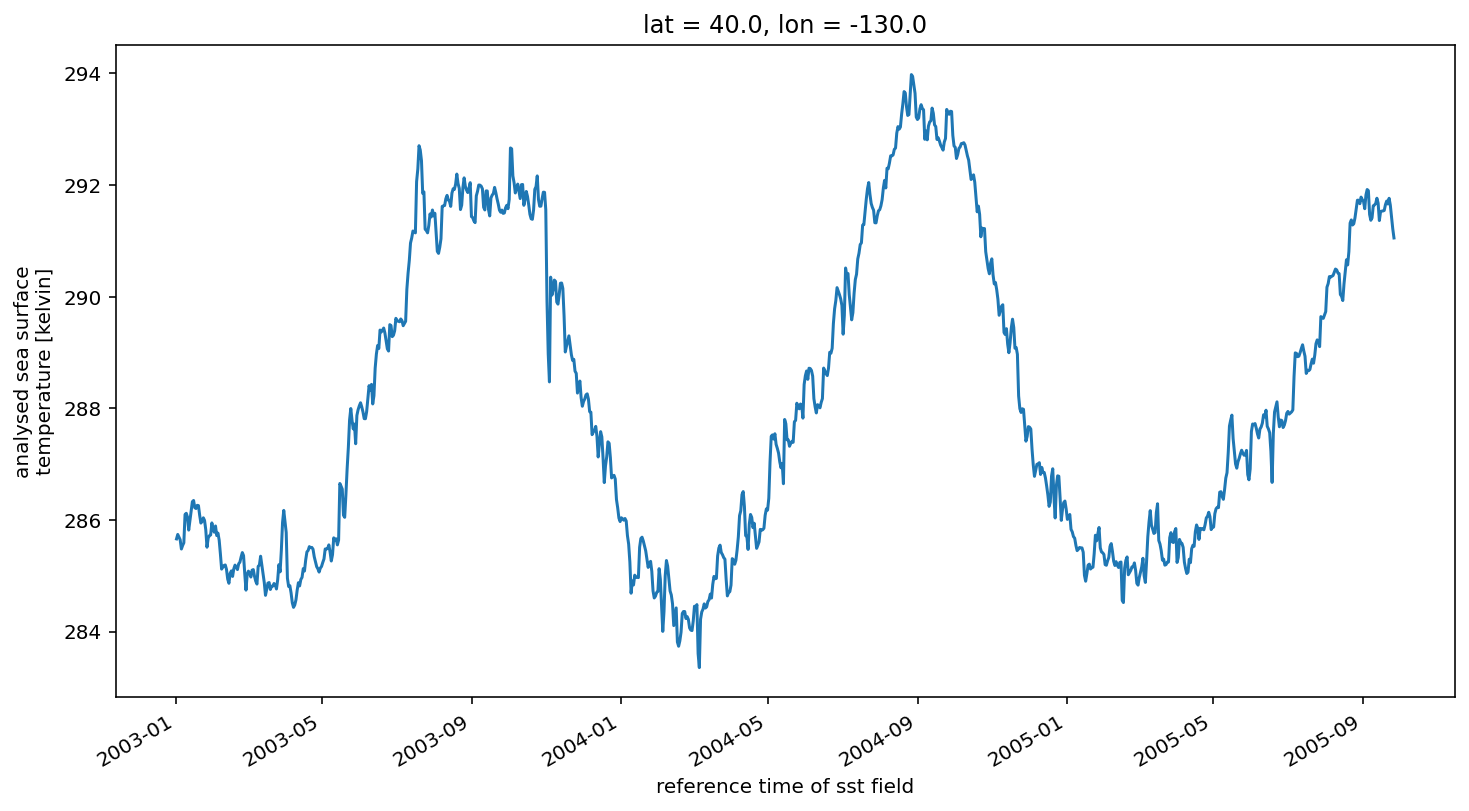

In [9]:
sst_timeseries.plot()

### Test 3:
Single Grid Cell; 6443 time slices

**Note that the temporal extent of the Zarr store is 2002-06-01 to 2020-01-20. This results in only 6443 time steps even though our testing contraints are set at 7014 for the entire temporal range of the native collection.**

In [10]:
times = []
for i in range(10):
    t0 = time.time()
    file_location = 's3://mur-sst/zarr'

    ikey = fsspec.get_mapper(file_location, anon=True)

    ds_sst = xr.open_zarr(ikey,consolidated=True)
    
    sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2002-05-31','2021-08-12'),
                                                lat  = 40,
                                                lon  = -130 
                                               ).load()
    
    wall_time = time.time() - t0
    times.append(wall_time)
    print (wall_time, "seconds wall time")
    ds_sst 
    
print("mean wall time:", mean(times), "stdev wall time:", stdev(times))

3.983454942703247 seconds wall time
4.186353445053101 seconds wall time
3.996570110321045 seconds wall time
3.855009078979492 seconds wall time
3.9250717163085938 seconds wall time
3.798931837081909 seconds wall time
3.8281779289245605 seconds wall time
3.9070019721984863 seconds wall time
3.8405160903930664 seconds wall time
3.88720440864563 seconds wall time
mean wall time: 3.920829153060913 stdev wall time: 0.11339572823988679


In [11]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 6443)>
array([286.425  , 285.87   , 285.901  , ..., 285.66498, 285.53998,
       285.666  ], dtype=float32)
Coordinates:
    lat      float32 40.0
    lon      float32 -130.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-20T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

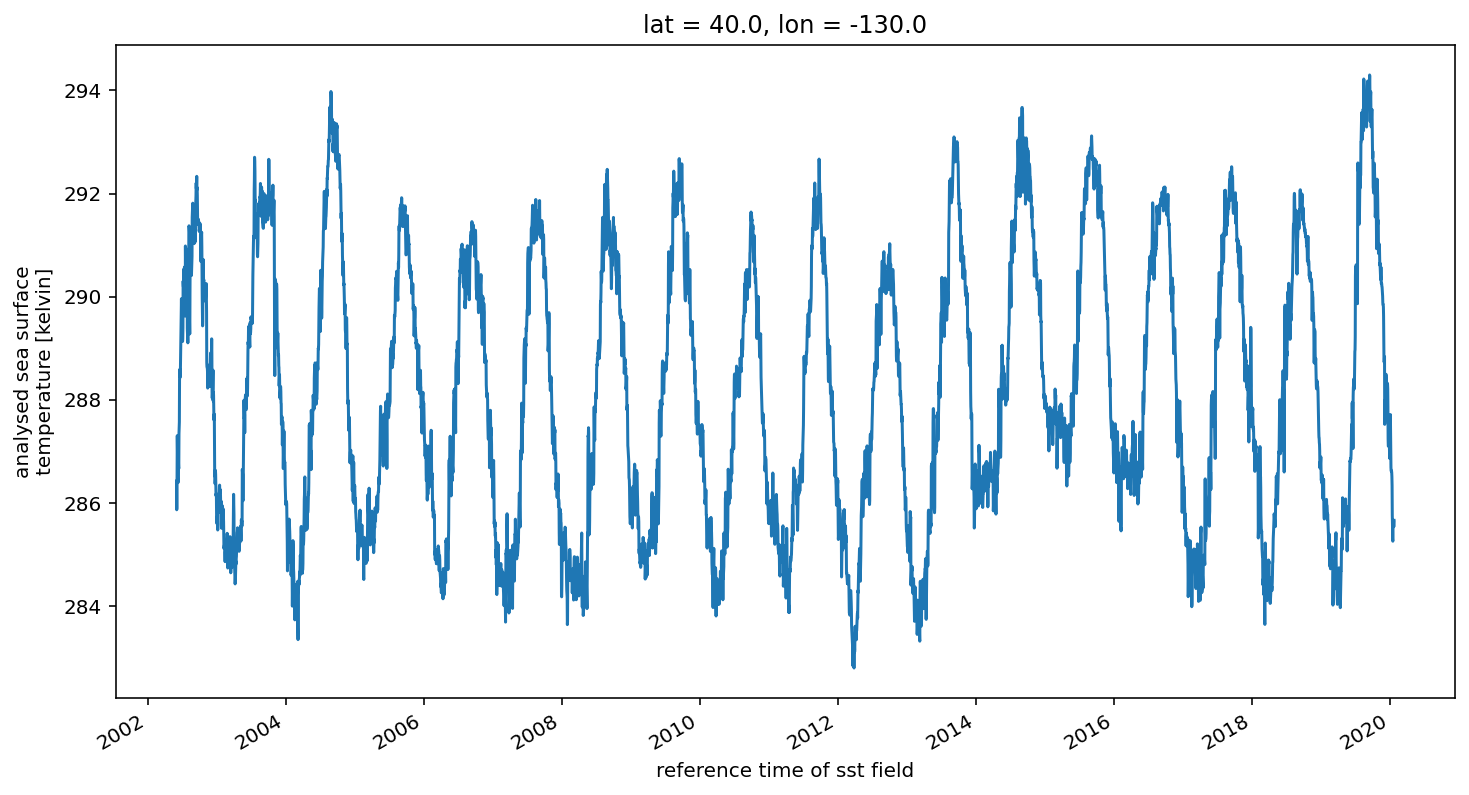

In [12]:
sst_timeseries.plot()

### Test 4:
3x3 grid cells; 100 time slices

In [13]:
times = []
for i in range(10):
    t0 = time.time()
    file_location = 's3://mur-sst/zarr'

    ikey = fsspec.get_mapper(file_location, anon=True)

    ds_sst = xr.open_zarr(ikey,consolidated=True)
    
    sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2003-01-01','2003-04-10'),
                                            lat  = slice(39.975,40),
                                            lon  = slice(-130,-129.974) 
                                           ).load()
    
    wall_time = time.time() - t0
    times.append(wall_time)
    print (wall_time, "seconds wall time")
    ds_sst 
    
print("mean wall time:", mean(times), "stdev wall time:", stdev(times))

5.6188671588897705 seconds wall time
6.960495948791504 seconds wall time
7.30262017250061 seconds wall time
4.257254123687744 seconds wall time
3.773092269897461 seconds wall time
4.518505573272705 seconds wall time
3.799037218093872 seconds wall time
4.004382610321045 seconds wall time
3.811983585357666 seconds wall time
4.078139066696167 seconds wall time
mean wall time: 4.8124377727508545 stdev wall time: 1.3399996585148939


In [14]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 100, lat: 3, lon: 3)>
array([[[285.673  , 285.676  , 285.67798],
        [285.662  , 285.668  , 285.673  ],
        [285.659  , 285.668  , 285.675  ]],

       [[285.742  , 285.741  , 285.74   ],
        [285.74   , 285.73898, 285.738  ],
        [285.73898, 285.738  , 285.737  ]],

       [[285.685  , 285.688  , 285.689  ],
        [285.689  , 285.69   , 285.69   ],
        [285.69098, 285.69098, 285.689  ]],

       [[285.603  , 285.613  , 285.617  ],
        [285.636  , 285.63998, 285.639  ],
        [285.64398, 285.645  , 285.64398]],

       [[285.44   , 285.444  , 285.44998],
        [285.471  , 285.474  , 285.475  ],
        [285.478  , 285.484  , 285.486  ]],

...

       [[284.50198, 284.509  , 284.516  ],
        [284.508  , 284.51498, 284.522  ],
        [284.514  , 284.521  , 284.52798]],

       [[284.452  , 284.46   , 284.468  ],
        [284.443  , 284.451  , 284.45898],
        [284.43298, 284.442  , 284.44998]],

       [[284.505  , 284.52298, 284.541  ],
        [284.49   , 284.507  , 284.525  ],
        [284.474  , 284.491  , 284.509  ]],

       [[284.611  , 284.641  , 284.673  ],
        [284.59   , 284.619  , 284.649  ],
        [284.567  , 284.596  , 284.625  ]],

       [[284.77   , 284.781  , 284.793  ],
        [284.755  , 284.764  , 284.774  ],
        [284.74   , 284.748  , 284.75598]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 39.98 39.99 40.0
  * lon      (lon) float32 -130.0 -130.0 -130.0
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-04-10T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

(array([ 32.,  80., 144., 189.,  71.,  48., 105.,  87.,  84.,  60.]),
 array([284.43298, 284.62448, 284.81598, 285.00748, 285.19897, 285.3905 ,
        285.582  , 285.7735 , 285.965  , 286.1565 , 286.348  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

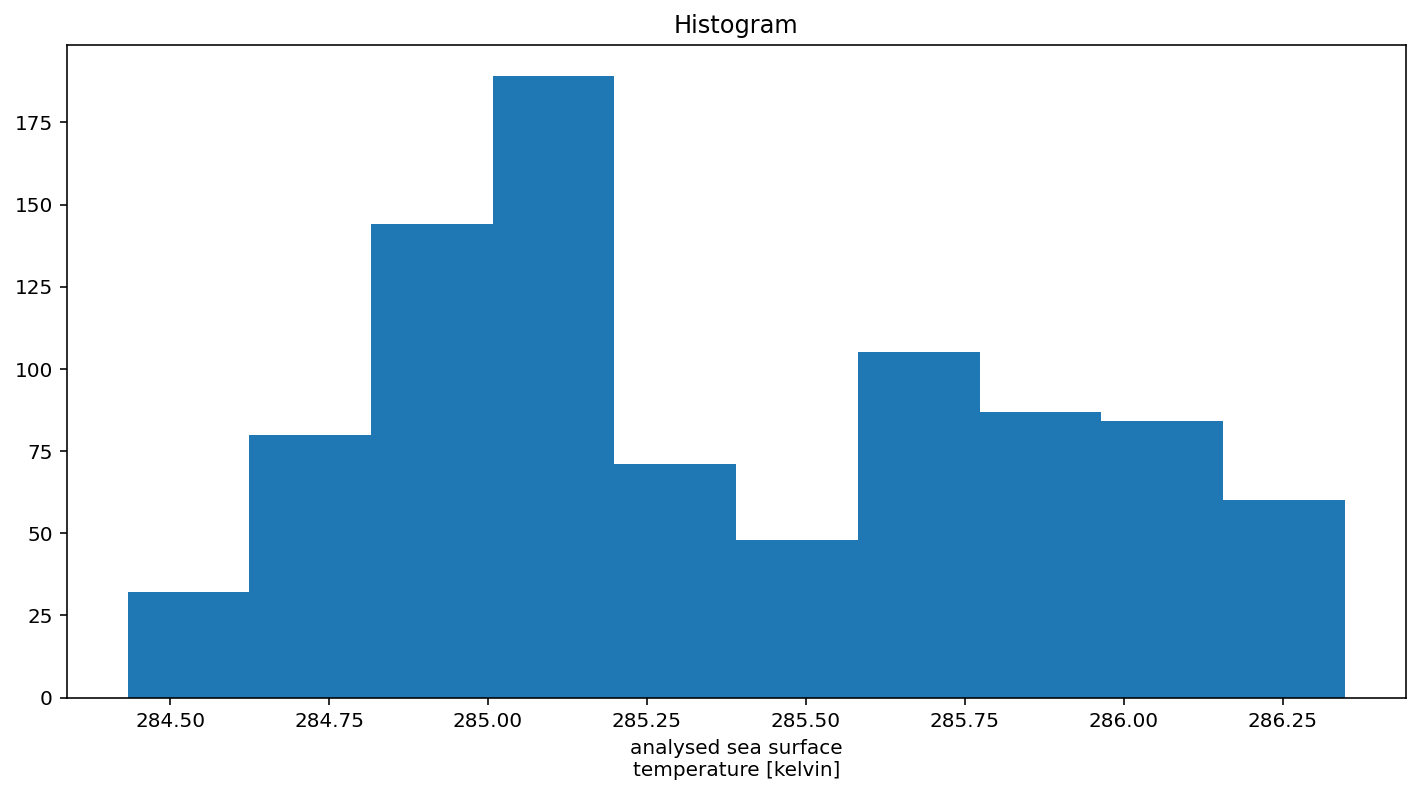

In [15]:
sst_timeseries.plot()

### Test 5:
3x3 grid cells; 1000 time slices

In [16]:
times = []
for i in range(10):
    t0 = time.time()
    file_location = 's3://mur-sst/zarr'

    ikey = fsspec.get_mapper(file_location, anon=True)

    ds_sst = xr.open_zarr(ikey,consolidated=True)
    
    sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2003-01-01','2005-09-26'),
                                            lat  = slice(39.975,40),
                                            lon  = slice(-130,-129.974) 
                                           ).load()
    
    wall_time = time.time() - t0
    times.append(wall_time)
    print (wall_time, "seconds wall time")
    ds_sst 
    
print("mean wall time:", mean(times), "stdev wall time:", stdev(times))

3.9716546535491943 seconds wall time
4.0373148918151855 seconds wall time
4.002258777618408 seconds wall time
4.032001256942749 seconds wall time
3.859490394592285 seconds wall time
4.06972861289978 seconds wall time
4.272473096847534 seconds wall time
3.8686351776123047 seconds wall time
4.188934087753296 seconds wall time
4.024413108825684 seconds wall time
mean wall time: 4.032690405845642 stdev wall time: 0.12690059063360185


In [17]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 1000, lat: 3, lon: 3)>
array([[[285.673  , 285.676  , 285.67798],
        [285.662  , 285.668  , 285.673  ],
        [285.659  , 285.668  , 285.675  ]],

       [[285.742  , 285.741  , 285.74   ],
        [285.74   , 285.73898, 285.738  ],
        [285.73898, 285.738  , 285.737  ]],

       [[285.685  , 285.688  , 285.689  ],
        [285.689  , 285.69   , 285.69   ],
        [285.69098, 285.69098, 285.689  ]],

       ...,

       [[291.548  , 291.531  , 291.50598],
        [291.47598, 291.451  , 291.426  ],
        [291.425  , 291.40698, 291.396  ]],

       [[291.25998, 291.227  , 291.18298],
        [291.229  , 291.192  , 291.145  ],
        [291.215  , 291.179  , 291.134  ]],

       [[291.04   , 291.017  , 290.994  ],
        [291.044  , 291.022  , 290.999  ],
        [291.051  , 291.031  , 291.009  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 39.98 39.99 40.0
  * lon      (lon) float32 -130.0 -130.0 -130.0
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2005-09-26T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

(array([ 195., 1847., 1571.,  798.,  944.,  794.,  574., 1158.,  792.,
         327.]),
 array([283.34   , 284.40408, 285.4682 , 286.5323 , 287.5964 , 288.6605 ,
        289.72458, 290.7887 , 291.85278, 292.9169 , 293.981  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

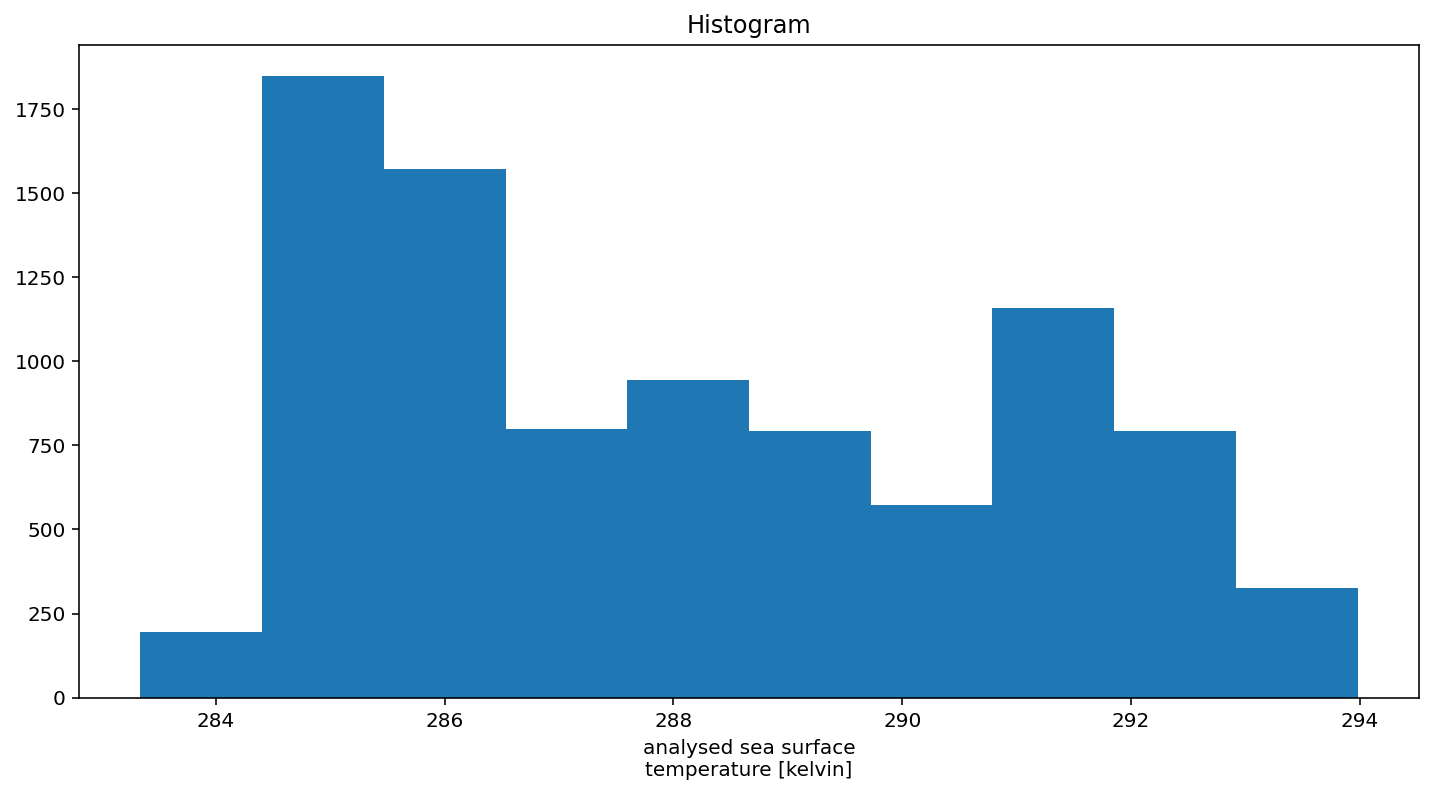

In [18]:
sst_timeseries.plot()

### Test 6:
3x3 grid cells; 6443 time slices

**Note that the temporal extent of the Zarr store is 2002-06-01 to 2020-01-20. This results in only 6443 time steps even though our testing contraints are set at 7014 for the entire temporal range of the native collection.**

In [19]:
times = []
for i in range(10):
    t0 = time.time()
    file_location = 's3://mur-sst/zarr'

    ikey = fsspec.get_mapper(file_location, anon=True)

    ds_sst = xr.open_zarr(ikey,consolidated=True)
    
    sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2002-05-31','2021-08-12'),
                                            lat  = slice(39.975,40),
                                            lon  = slice(-130,-129.974) 
                                           ).load()
    
    wall_time = time.time() - t0
    times.append(wall_time)
    print (wall_time, "seconds wall time")
    ds_sst 
    
print("mean wall time:", mean(times), "stdev wall time:", stdev(times))

4.015658378601074 seconds wall time
3.878627300262451 seconds wall time
4.045401334762573 seconds wall time
3.796623945236206 seconds wall time
4.04405665397644 seconds wall time
3.843679904937744 seconds wall time
3.8635904788970947 seconds wall time
3.979586362838745 seconds wall time
4.006497859954834 seconds wall time
3.760960102081299 seconds wall time
mean wall time: 3.923468232154846 stdev wall time: 0.10667293362162009


In [20]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 6443, lat: 3, lon: 3)>
array([[[286.417  , 286.434  , 286.45398],
        [286.422  , 286.443  , 286.46698],
        [286.425  , 286.448  , 286.475  ]],

       [[285.874  , 285.886  , 285.904  ],
        [285.876  , 285.88998, 285.91098],
        [285.87   , 285.884  , 285.904  ]],

       [[285.914  , 285.929  , 285.952  ],
        [285.90298, 285.921  , 285.94598],
        [285.901  , 285.917  , 285.938  ]],

       ...,

       [[285.721  , 285.716  , 285.711  ],
        [285.693  , 285.689  , 285.684  ],
        [285.66498, 285.66098, 285.658  ]],

       [[285.554  , 285.54898, 285.544  ],
        [285.548  , 285.542  , 285.535  ],
        [285.53998, 285.533  , 285.524  ]],

       [[285.63998, 285.632  , 285.625  ],
        [285.654  , 285.642  , 285.632  ],
        [285.666  , 285.652  , 285.638  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 39.98 39.99 40.0
  * lon      (lon) float32 -130.0 -130.0 -130.0
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-20T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

(array([ 736., 7766., 8788., 8353., 6972., 6022., 7427., 7778., 3295.,
         850.]),
 array([282.80298, 283.95258, 285.10217, 286.25177, 287.40137, 288.55096,
        289.7006 , 290.8502 , 291.9998 , 293.14938, 294.29898],
       dtype=float32),
 <BarContainer object of 10 artists>)

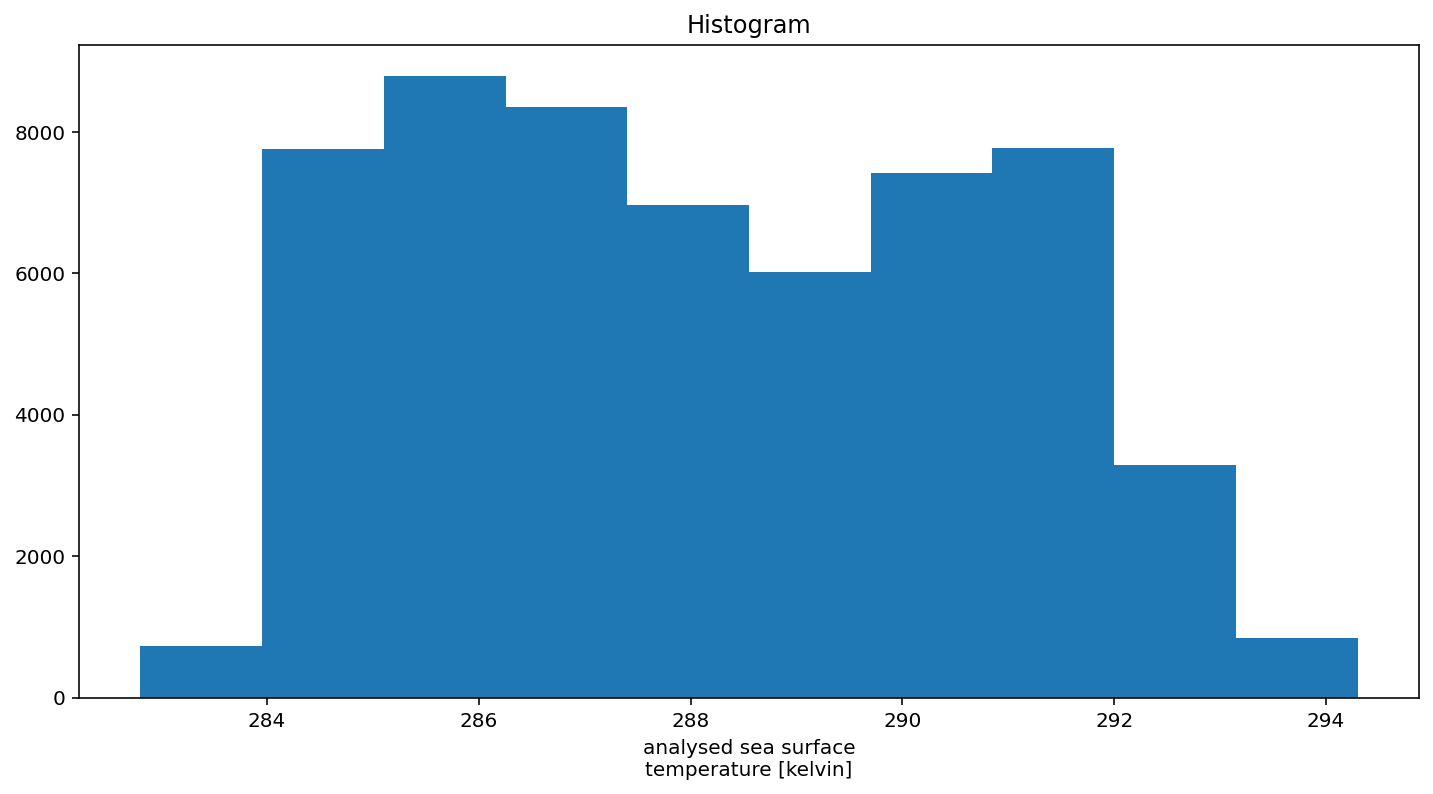

In [21]:
sst_timeseries.plot()

### Test 7:
10x10 grid cells; 100 time slices

In [22]:
times = []
for i in range(10):
    t0 = time.time()
    file_location = 's3://mur-sst/zarr'

    ikey = fsspec.get_mapper(file_location, anon=True)

    ds_sst = xr.open_zarr(ikey,consolidated=True)
    
    sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2003-01-01','2003-04-10'),
                                            lat  = slice(39.905,40),
                                            lon  = slice(-130,-129.91) 
                                           ).load()
    
    wall_time = time.time() - t0
    times.append(wall_time)
    print (wall_time, "seconds wall time")
    ds_sst 
    
print("mean wall time:", mean(times), "stdev wall time:", stdev(times))

4.026249170303345 seconds wall time
4.001231908798218 seconds wall time
3.8114099502563477 seconds wall time
3.908531427383423 seconds wall time
3.893019676208496 seconds wall time
3.734980821609497 seconds wall time
3.9416208267211914 seconds wall time
3.7549376487731934 seconds wall time
3.7355291843414307 seconds wall time
3.9719839096069336 seconds wall time
mean wall time: 3.8779494524002076 stdev wall time: 0.11132197227287158


In [23]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 100, lat: 10, lon: 10)>
array([[[285.809  , 285.815  , 285.819  , ..., 285.78198, 285.774  ,
         285.77   ],
        [285.792  , 285.798  , 285.8    , ..., 285.759  , 285.749  ,
         285.74298],
        [285.772  , 285.77798, 285.78   , ..., 285.737  , 285.72598,
         285.71698],
        ...,
        [285.673  , 285.676  , 285.67798, ..., 285.667  , 285.656  ,
         285.643  ],
        [285.662  , 285.668  , 285.673  , ..., 285.669  , 285.66   ,
         285.65   ],
        [285.659  , 285.668  , 285.675  , ..., 285.67798, 285.672  ,
         285.664  ]],

       [[285.763  , 285.762  , 285.75998, ..., 285.751  , 285.749  ,
         285.74698],
        [285.75998, 285.759  , 285.757  , ..., 285.74698, 285.745  ,
         285.74298],
        [285.75598, 285.755  , 285.754  , ..., 285.744  , 285.741  ,
         285.73898],
...
        [284.611  , 284.641  , 284.673  , ..., 284.849  , 284.889  ,
         284.932  ],
        [284.59   , 284.619  , 284.649  , ..., 284.81598, 284.85098,
         284.889  ],
        [284.567  , 284.596  , 284.625  , ..., 284.78198, 284.814  ,
         284.849  ]],

       [[284.884  , 284.901  , 284.922  , ..., 285.065  , 285.09198,
         285.117  ],
        [284.866  , 284.883  , 284.90298, ..., 285.043  , 285.073  ,
         285.1    ],
        [284.849  , 284.866  , 284.88498, ..., 285.024  , 285.057  ,
         285.08798],
        ...,
        [284.77   , 284.781  , 284.793  , ..., 284.87698, 284.90198,
         284.93698],
        [284.755  , 284.764  , 284.774  , ..., 284.837  , 284.849  ,
         284.873  ],
        [284.74   , 284.748  , 284.75598, ..., 284.802  , 284.81   ,
         284.82898]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 39.91 39.92 39.93 39.94 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float32 -130.0 -130.0 -130.0 -130.0 ... -129.9 -129.9 -129.9
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-04-10T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

(array([ 316., 1114., 1663., 1800.,  880.,  671., 1082., 1198.,  926.,
         350.]),
 array([284.43298, 284.62988, 284.82678, 285.02368, 285.22058, 285.41748,
        285.6144 , 285.8113 , 286.0082 , 286.2051 , 286.402  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

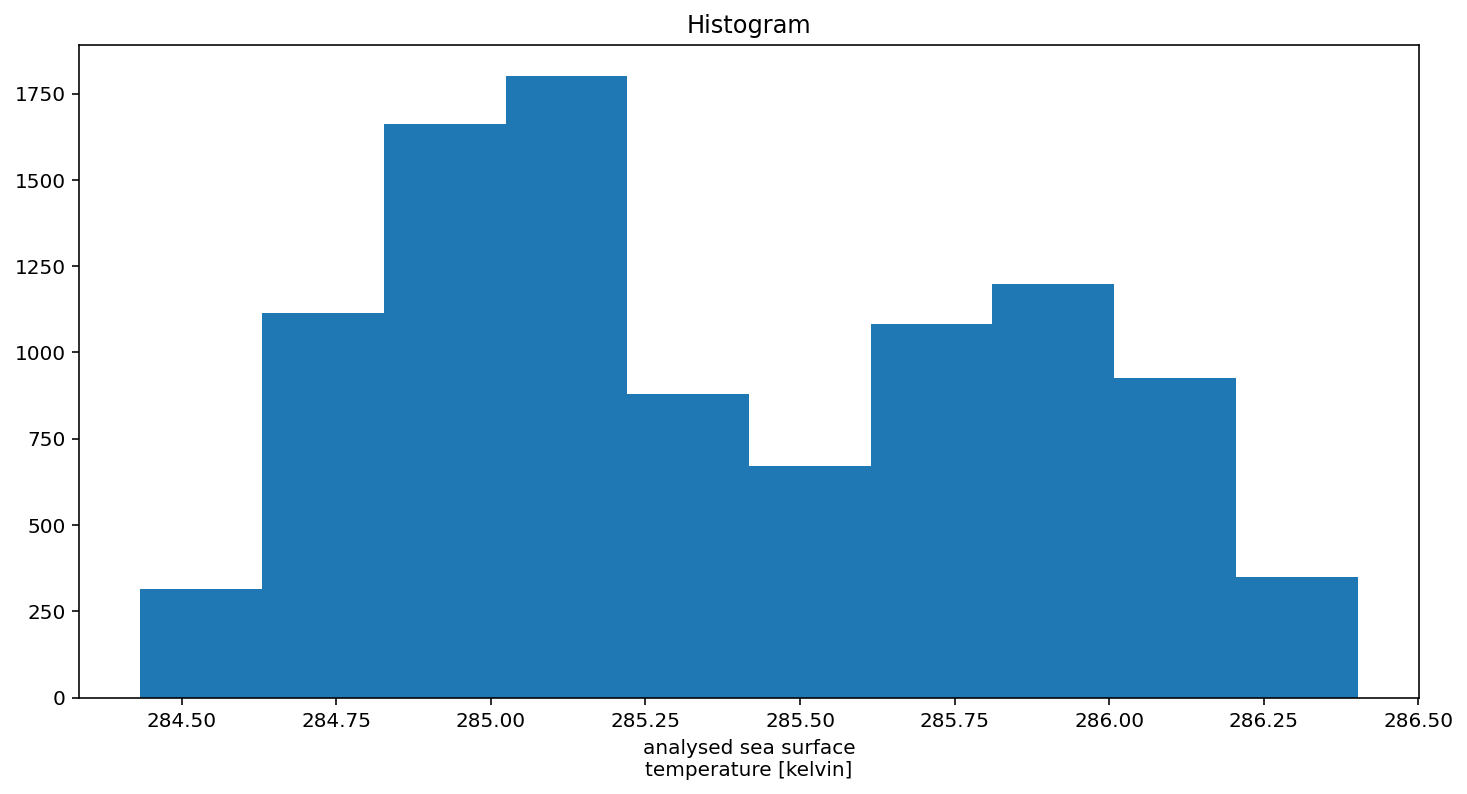

In [24]:
sst_timeseries.plot()

### Test 8:
10x10 grid cells; 1000 time slices

In [25]:
times = []
for i in range(10):
    t0 = time.time()
    file_location = 's3://mur-sst/zarr'

    ikey = fsspec.get_mapper(file_location, anon=True)

    ds_sst = xr.open_zarr(ikey,consolidated=True)
    
    sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2003-01-01','2005-09-26'),
                                            lat  = slice(39.905,40),
                                            lon  = slice(-130,-129.91) 
                                           ).load()
    
    wall_time = time.time() - t0
    times.append(wall_time)
    print (wall_time, "seconds wall time")
    ds_sst 
    
print("mean wall time:", mean(times), "stdev wall time:", stdev(times))

3.8102517127990723 seconds wall time
3.8270812034606934 seconds wall time
3.925851821899414 seconds wall time
3.9664528369903564 seconds wall time
4.000888347625732 seconds wall time
3.8037819862365723 seconds wall time
4.002865314483643 seconds wall time
3.8472864627838135 seconds wall time
4.31350040435791 seconds wall time
4.646752595901489 seconds wall time
mean wall time: 4.014471268653869 stdev wall time: 0.268501576115842


In [26]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 1000, lat: 10, lon: 10)>
array([[[285.809  , 285.815  , 285.819  , ..., 285.78198, 285.774  ,
         285.77   ],
        [285.792  , 285.798  , 285.8    , ..., 285.759  , 285.749  ,
         285.74298],
        [285.772  , 285.77798, 285.78   , ..., 285.737  , 285.72598,
         285.71698],
        ...,
        [285.673  , 285.676  , 285.67798, ..., 285.667  , 285.656  ,
         285.643  ],
        [285.662  , 285.668  , 285.673  , ..., 285.669  , 285.66   ,
         285.65   ],
        [285.659  , 285.668  , 285.675  , ..., 285.67798, 285.672  ,
         285.664  ]],

       [[285.763  , 285.762  , 285.75998, ..., 285.751  , 285.749  ,
         285.74698],
        [285.75998, 285.759  , 285.757  , ..., 285.74698, 285.745  ,
         285.74298],
        [285.75598, 285.755  , 285.754  , ..., 285.744  , 285.741  ,
         285.73898],
...
        [291.25998, 291.227  , 291.18298, ..., 290.91998, 290.953  ,
         291.005  ],
        [291.229  , 291.192  , 291.145  , ..., 290.86398, 290.90698,
         290.969  ],
        [291.215  , 291.179  , 291.134  , ..., 290.884  , 290.916  ,
         290.966  ]],

       [[291.041  , 291.005  , 290.972  , ..., 290.914  , 290.91998,
         290.926  ],
        [291.038  , 291.005  , 290.974  , ..., 290.913  , 290.916  ,
         290.91998],
        [291.03598, 291.007  , 290.97998, ..., 290.915  , 290.914  ,
         290.916  ],
        ...,
        [291.04   , 291.017  , 290.994  , ..., 290.904  , 290.904  ,
         290.90698],
        [291.044  , 291.022  , 290.999  , ..., 290.905  , 290.906  ,
         290.91   ],
        [291.051  , 291.031  , 291.009  , ..., 290.91998, 290.918  ,
         290.919  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 39.91 39.92 39.93 39.94 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float32 -130.0 -130.0 -130.0 -130.0 ... -129.9 -129.9 -129.9
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2005-09-26T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

(array([ 2378., 20120., 17569.,  9019., 10509.,  8827.,  6156., 13195.,
         8317.,  3910.]),
 array([283.33398, 284.39868, 285.46338, 286.52808, 287.59277, 288.65747,
        289.7222 , 290.7869 , 291.8516 , 292.9163 , 293.981  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

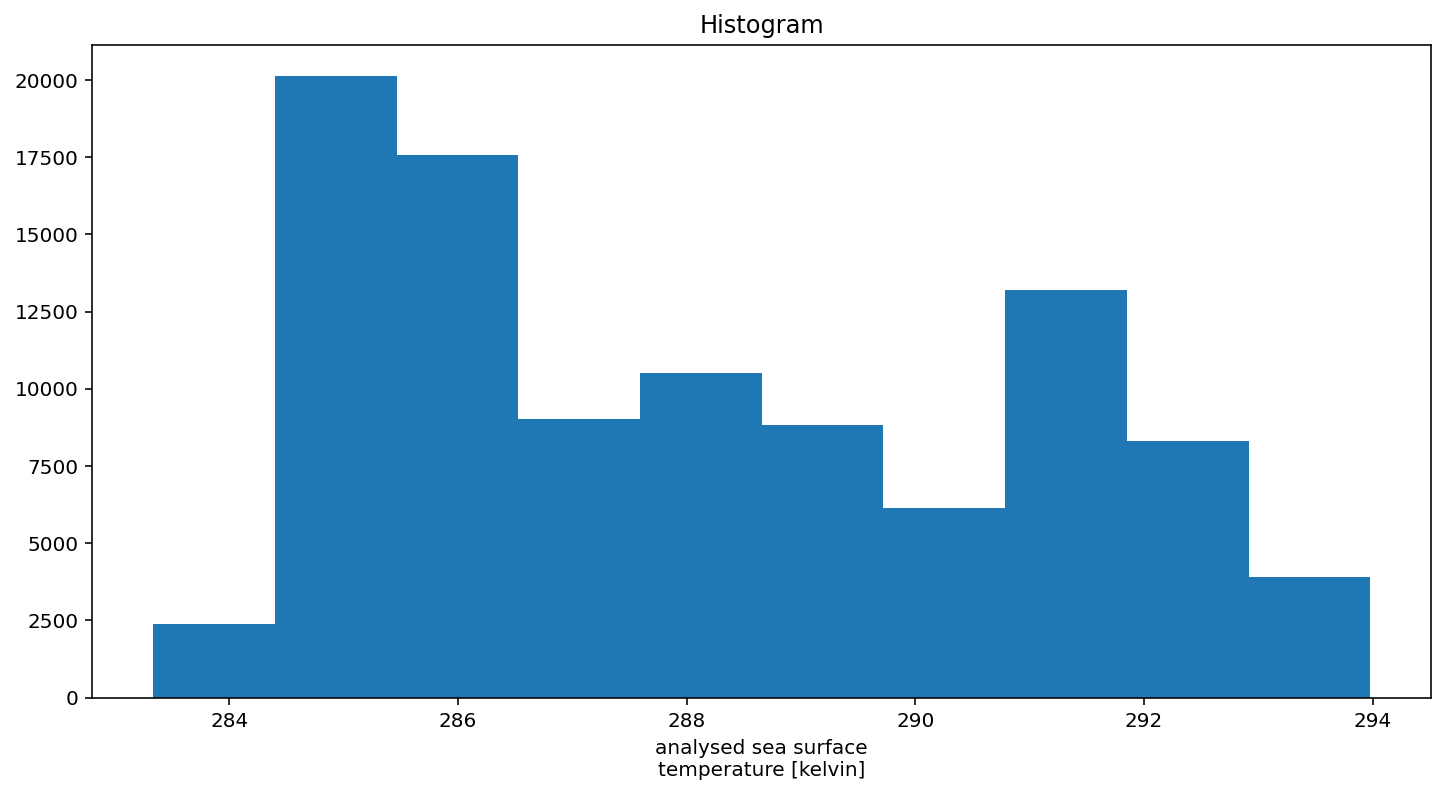

In [27]:
sst_timeseries.plot()

### Test 9:
10x10 grid cells; 6443 time slices

**Note that the temporal extent of the Zarr store is 2002-06-01 to 2020-01-20. This results in only 6443 time steps even though our testing contraints are set at 7014 for the entire temporal range of the native collection.**

In [28]:
times = []
for i in range(10):
    t0 = time.time()
    file_location = 's3://mur-sst/zarr'

    ikey = fsspec.get_mapper(file_location, anon=True)

    ds_sst = xr.open_zarr(ikey,consolidated=True)
    
    sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2002-05-31','2021-08-12'),
                                            lat  = slice(39.905,40),
                                            lon  = slice(-130,-129.91) 
                                           ).load()
    
    wall_time = time.time() - t0
    times.append(wall_time)
    print (wall_time, "seconds wall time")
    ds_sst 
    
print("mean wall time:", mean(times), "stdev wall time:", stdev(times))

4.041990280151367 seconds wall time
3.920734405517578 seconds wall time
4.02324914932251 seconds wall time
3.856292486190796 seconds wall time
4.013493776321411 seconds wall time
4.1440956592559814 seconds wall time
3.8845462799072266 seconds wall time
3.8556439876556396 seconds wall time
3.8382251262664795 seconds wall time
4.440647602081299 seconds wall time
mean wall time: 4.001891875267029 stdev wall time: 0.1839861342709082


In [29]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 6443, lat: 10, lon: 10)>
array([[[286.421  , 286.413  , 286.405  , ..., 286.376  , 286.37   ,
         286.363  ],
        [286.409  , 286.40298, 286.397  , ..., 286.383  , 286.379  ,
         286.373  ],
        [286.402  , 286.399  , 286.397  , ..., 286.40298, 286.4    ,
         286.39398],
        ...,
        [286.417  , 286.434  , 286.45398, ..., 286.538  , 286.539  ,
         286.53   ],
        [286.422  , 286.443  , 286.46698, ..., 286.56   , 286.554  ,
         286.539  ],
        [286.425  , 286.448  , 286.475  , ..., 286.58798, 286.573  ,
         286.547  ]],

       [[285.92398, 285.901  , 285.883  , ..., 285.88098, 285.887  ,
         285.893  ],
        [285.89398, 285.87698, 285.86398, ..., 285.893  , 285.906  ,
         285.916  ],
        [285.878  , 285.866  , 285.858  , ..., 285.917  , 285.93698,
         285.95398],
...
        [285.554  , 285.54898, 285.544  , ..., 285.505  , 285.494  ,
         285.483  ],
        [285.548  , 285.542  , 285.535  , ..., 285.48898, 285.477  ,
         285.465  ],
        [285.53998, 285.533  , 285.524  , ..., 285.472  , 285.46   ,
         285.447  ]],

       [[285.573  , 285.589  , 285.604  , ..., 285.642  , 285.646  ,
         285.65   ],
        [285.574  , 285.58798, 285.6    , ..., 285.632  , 285.63498,
         285.638  ],
        [285.58   , 285.59   , 285.599  , ..., 285.625  , 285.62698,
         285.628  ],
        ...,
        [285.63998, 285.632  , 285.625  , ..., 285.594  , 285.589  ,
         285.58398],
        [285.654  , 285.642  , 285.632  , ..., 285.589  , 285.582  ,
         285.57498],
        [285.666  , 285.652  , 285.638  , ..., 285.583  , 285.574  ,
         285.56598]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 39.91 39.92 39.93 39.94 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float32 -130.0 -130.0 -130.0 -130.0 ... -129.9 -129.9 -129.9
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-20T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

(array([ 7933., 86708., 99047., 91908., 79244., 67972., 84942., 84630.,
        33867.,  8049.]),
 array([282.80298, 283.9615 , 285.12   , 286.27847, 287.43698, 288.5955 ,
        289.754  , 290.9125 , 292.07098, 293.2295 , 294.388  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

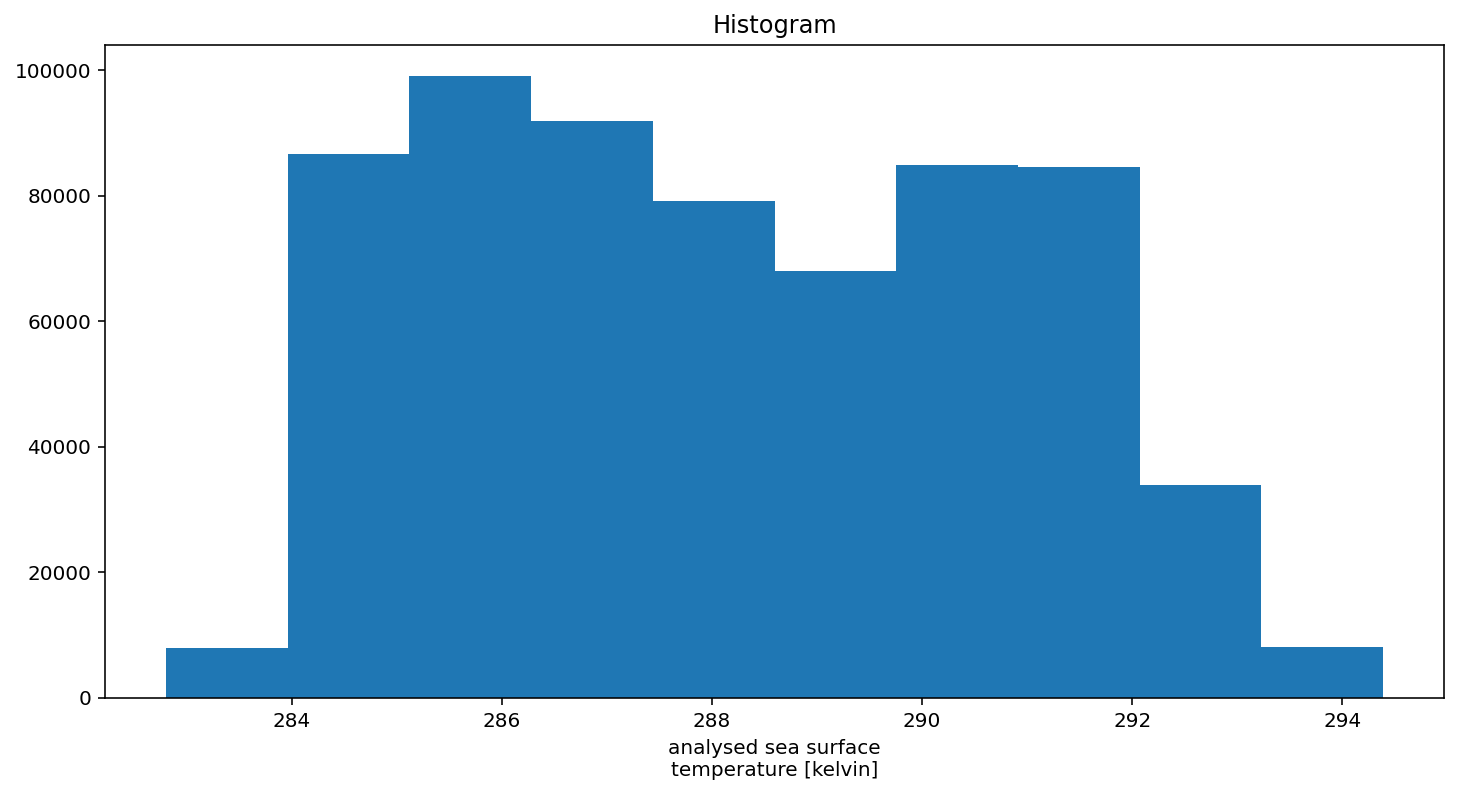

In [30]:
sst_timeseries.plot()

# The rest of this notebook is a copy from the Pangeo notebook referenced above.

### Read entire 10 years of data at 1 point.

Select the ``analysed_sst`` variable over a specific time period, `lat`, and `lon` and load the data into memory.  This is small enough to load into memory which will make calculating climatologies easier in the next step.

In [31]:
# %%time

# sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2010-01-01','2020-01-01'),
#                                             lat  = 47,
#                                             lon  = -145
#                                            ).load()

# sst_timeseries.plot()

### The anomaly is more interesting...  

Use [.groupby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html#xarray-dataarray-groupby) method to calculate the climatology and [.resample](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html#xarray-dataset-resample) method to then average it into 1-month bins.
- [DataArray.mean](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray-dataarray-mean) arguments are important! Xarray uses metadata to plot, so keep_attrs is a nice feature.  Also, for SST there are regions with changing sea ice.  Setting skipna = False removes these regions. 

In [32]:
# %%time

# sst_climatology = sst_timeseries.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

# sst_anomaly = sst_timeseries.groupby('time.dayofyear')-sst_climatology

# sst_anomaly_monthly = sst_anomaly.resample(time='1MS').mean(keep_attrs=True,skipna=False)

# #plot the data
# sst_anomaly.plot()
# sst_anomaly_monthly.plot()
# plt.axhline(linewidth=2,color='k')

# Chukchi Sea SST timeseries

# Note SST is set to -1.8 C (271.35 K) when ice is present

In [33]:
# sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2010-01-01','2020-01-01'),
#                                             lat  = 72,
#                                             lon  = -171
#                                            ).load()

# sst_timeseries.plot()

# Grid resolution does NOT equal spatial resolution

- many L4 SST analyses blend infrared (~ 1 - 4 km data) with passive microwave (~ 50 km) data.  Data availability will determine regional / temporal changes in spatial resolution

- many L4 SST analyses apply smoothing filters that may further reduce resolution

In [34]:
# %%time

# subset = ds_sst['analysed_sst'].sel(time='2019-06-01',lat=slice(35,40),lon=slice(-126,-120))

# subset.plot(vmin=282,vmax=289,cmap='inferno')

In [35]:
# %%time

# subset = ds_sst['analysed_sst'].sel(time='2019-05-15',lat=slice(35,40),lon=slice(-126,-120))

# subset.plot(vmin=282,vmax=289,cmap='inferno')